In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
from tqdm import tqdm_notebook
import math

In [2]:
# PARAMETERS -----
# change_in_reaction: current reaction time of each county + change_in_reaction
# memory_length: the memory length of the autoregressive model to choose which to fit 
change_in_reaction = -10
memory_length = 7
#------------------

In [3]:
master_df = pd.read_csv('../processed_data/google_data/master_df_counties.csv')
master_df['county_st'] = master_df['county'].astype(str) + ', ' + master_df['state'].astype(str)
master_df.head()

,state,county,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential,cases,deaths,county_st
0,Alabama,Baldwin County,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0,0.0,0.0,"Baldwin County, Alabama"
1,Alabama,Baldwin County,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0,0.0,0.0,"Baldwin County, Alabama"
2,Alabama,Baldwin County,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0,0.0,0.0,"Baldwin County, Alabama"
3,Alabama,Baldwin County,2020-02-18,7.0,8.0,21.0,7.5,2.0,0.0,0.0,0.0,"Baldwin County, Alabama"
4,Alabama,Baldwin County,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0,0.0,0.0,"Baldwin County, Alabama"


In [4]:
#master_df = master_df.dropna() # TODO not sure if this is the only thing we canz do 
unique_county_st = master_df['county_st'].unique()
master_df.reset_index(drop = True, inplace = True)
len(unique_county_st)
master_df.dropna(inplace = True)


In [5]:
unique_county_st = master_df['county_st'].unique() 
# find the date of the first case for every county
for county_st in tqdm_notebook(unique_county_st): 
    county_st_idx = np.where(master_df['county_st'] == county_st)[0]
    #t = np.arange(len(master_df['date'][county_st_idx]))
    y = master_df['cases'][county_st_idx]
    zero_days = len(y) - np.count_nonzero(y)
    
    
    if zero_days >= len(y)-1:
        # delete cases without any coronavirus data
        master_df.drop(county_st_idx, inplace = True)
        master_df.reset_index(drop = True, inplace = True)
    

no cases here Floyd County, Iowa
no cases here Fremont County, Iowa
no cases here Dickinson County, Kansas
no cases here Ellis County, Kansas
no cases here Thomas County, Kansas
no cases here Gallatin County, Kentucky
no cases here Nobles County, Minnesota
no cases here Lawrence County, Missouri
no cases here Mississippi County, Missouri
no cases here Big Horn County, Montana
no cases here Deuel County, Nebraska
no cases here Mineral County, Nevada
no cases here Guadalupe County, New Mexico
no cases here Hidalgo County, New Mexico
no cases here Luna County, New Mexico
no cases here Quay County, New Mexico
no cases here Union County, New Mexico
no cases here Kings County, New York
no cases here Richmond County, New York
no cases here Okfuskee County, Oklahoma
no cases here Baker County, Oregon
no cases here Jefferson County, Oregon
no cases here Brooks County, Texas
no cases here Carson County, Texas
no cases here Dimmit County, Texas
no cases here Freestone County, Texas
no cases here 

In [6]:
#master_df['cases'] = np.array(master_df['cases'])
#master_df['log_cases'] = np.log(master_df.cases)

In [7]:
# find the date of the first case for every county
def func(x, a,b):
    return a*((b)**x)

def fit(t, data):
    t = sm.add_constant(t)
    y = np.log(np.add(data,1))
    mod = sm.OLS(y,t)
    res = mod.fit()
    a = res.params[0]
    b = res.params[1]
    
    return np.exp(a),np.exp(b)

unique_county_st = master_df['county_st'].unique()


a_list = [] 
b_list = [] 
for county_st in tqdm_notebook(unique_county_st): 
    county_st_idx = np.where(master_df['county_st'] == county_st)[0]
    #t = np.arange(len(master_df['date'][county_st_idx]))
    y = master_df['cases'][county_st_idx].values
    zero_days = len(y) - np.count_nonzero(y)
    start_idx = zero_days
    end_idx = len(y)-1
    t = np.arange(np.count_nonzero(y)-1)
    data = np.array(y[start_idx:end_idx]) 
    a,b = fit(t,data)
    a_list.append(a)
    b_list.append(b)

parameters_df = pd.DataFrame(columns = ['county_st', 'a','b']) #y = ab^t
parameters_df['county_st'] = unique_county_st
parameters_df['a'] = a_list
parameters_df['b'] = b_list

In [8]:
parameters_df.to_csv('parameters.csv', index =None)

In [9]:
parameters_df

,county_st,a,b
0,"Baldwin County, Alabama",1.256289,1.162281
1,"Butler County, Alabama",1.719235,1.035724
2,"Chambers County, Alabama",2.017345,1.255564
3,"Chilton County, Alabama",4.695608,1.134233
4,"Cleburne County, Alabama",2.802048,1.118133
...,...,...,...
998,"Laramie County, Wyoming",3.979568,1.136261
999,"Natrona County, Wyoming",2.317183,1.156006
1000,"Sweetwater County, Wyoming",1.646982,1.099574
1001,"Teton County, Wyoming",2.067392,1.177271


In [10]:
reaction_df = pd.read_csv('../processed_data/google_data/county_gr_rt_transit.csv')
county_to_reaction=dict(zip(reaction_df['county'], reaction_df['reaction_time'])) 

In [11]:
parameters_df.insert(3, 'reaction_time', parameters_df['county_st'].map(county_to_reaction))

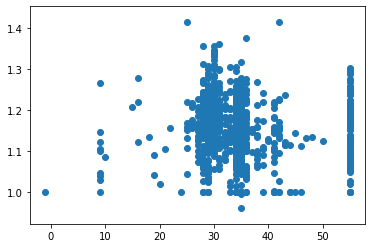

In [12]:
plt.scatter(parameters_df['reaction_time'],parameters_df['b'])

In [13]:
county_to_b=dict(zip(parameters_df['county_st'], parameters_df['b'])) 
county_to_a=dict(zip(parameters_df['county_st'], parameters_df['a'])) 

In [14]:
def b_new(b, reaction_time, change_in_reaction):
    y1 = 0.09704/(1+4.04421*math.exp(-0.424991*reaction_time)) + 1.07
    y2 = 0.09704/(1+4.04421*math.exp(-0.424991*(reaction_time + change_in_reaction))) + 1.07
    ret = b * (y2/y1)
    if ret <= 1.01: 
        return 1.01 # assume there is still moderate growth despite it going close to zero
    return ret

In [15]:
import numpy.linalg as npl
def reaction(t, reaction_change, M):
    if reaction_change == 0:
        return t
    elif reaction_change > 0:
        ret = np.zeros(len(t))
        ret[-(len(t)-reaction_change):] = t[:len(t)-reaction_change]
        return ret
    else:
        if(len(t) < M): #error check
            print("Error: memory length too long")
            return

        last = min(t)
        ret = np.ones(len(t))*last
        ret[:len(t)-2] = t[2:]
        N = len(t)
        ###regressive model starts here
        y = t[M:]
        t_no = t
        t = np.array(t)
        idx,_ = np.mgrid[0:N-M, 0:M] + np.arange(0,M)
        X = t[idx]

        #sol = npl.lstsq(X, y, rcond=None)
        sol = npl.lstsq(np.array(X, dtype = 'float'), np.array(t[M:], dtype ='float'))
        beta = np.array(sol[0])
        theta = sol[0]
        SSE = sol[1]

        future = -1 * reaction_change
        predict = X @ theta
        x = np.array(t[-M:])
        all_predictions = [] 
        for i in range(future): #create prediction values y and append to predict array
            #print(i)
            y = x @ theta
            if y <= -100: 
                y = -100 
            if y >= 100:
                y= 100
            all_predictions.append(y)
            predict = np.append(predict, y)
            x = np.append(x, y)
            x = np.delete(x, 0)


        ret = t_no[-(len(t) + reaction_change):] + all_predictions

        return(ret)

In [16]:
def func(x, a,b):
    return a*((b)**x)



pred_df = pd.DataFrame(columns = ['state', 'county','county_st', 'date','cases_pred', 'transit_pred'])

rows_list = []
for county_st in tqdm_notebook(unique_county_st): 
    county_st_idx = np.where(master_df['county_st'] == county_st)[0]
    #t = np.arange(len(master_df['date'][county_st_idx]))
    y = master_df['cases'][county_st_idx].values
    transit_series = list(master_df['transit stations'][county_st_idx].values)
    zero_days = len(y) - np.count_nonzero(y)
    start_idx = zero_days
    end_idx = len(y)-1
    t = np.arange(np.count_nonzero(y))
    total_t = np.arange(len(y))
    
    a = county_to_a[county_st]
    b = county_to_b[county_st]
    if county_st in county_to_reaction and b > 1:
        reaction_time = county_to_reaction[county_st]
        transit_reaction = np.array(reaction(transit_series,\
                                             reaction_change = change_in_reaction, M= memory_length))
        
        
        zeros = np.zeros(zero_days)
        new_b = b_new(b, reaction_time, change_in_reaction)
        pred = np.array(func(t, a, new_b)) # predicts from the first day there was a case to the last day
        total_pred = np.append(zeros, pred)
        if len(transit_reaction) != 56 or len(total_pred) != 56: 
            continue
        
        
        df = pd.DataFrame(columns = ['state', 'county','county_st', 'date','cases_pred', 'transit_pred'])
        
        df['state'] =  master_df['state'][county_st_idx]
        df['county'] = master_df['county'][county_st_idx]
        df['county_st'] = master_df['county_st'][county_st_idx]
        df['date'] = master_df['date'][county_st_idx]
        df['cases_pred'] = total_pred
        df['transit_pred'] = transit_reaction
        pred_df = pred_df.append(df)
        
    else:
        master_df.drop(county_st_idx, inplace = True)
        master_df.reset_index(drop = True, inplace = True)
        

/Users/thomastran/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [17]:
pred_df.head()

,state,county,county_st,date,cases_pred,transit_pred
0,Alabama,Baldwin County,"Baldwin County, Alabama",2020-02-15,0.0,2.0
1,Alabama,Baldwin County,"Baldwin County, Alabama",2020-02-16,0.0,8.0
2,Alabama,Baldwin County,"Baldwin County, Alabama",2020-02-17,0.0,7.0
3,Alabama,Baldwin County,"Baldwin County, Alabama",2020-02-18,0.0,9.0
4,Alabama,Baldwin County,"Baldwin County, Alabama",2020-02-19,0.0,16.0


In [18]:
pred_df.to_csv(f'output/output_change_({change_in_reaction})_memory_({memory_length}).csv',index = None)

In [19]:
master_df.head()

,state,county,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential,cases,deaths,county_st
0,Alabama,Baldwin County,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0,0.0,0.0,"Baldwin County, Alabama"
1,Alabama,Baldwin County,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0,0.0,0.0,"Baldwin County, Alabama"
2,Alabama,Baldwin County,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0,0.0,0.0,"Baldwin County, Alabama"
3,Alabama,Baldwin County,2020-02-18,7.0,8.0,21.0,7.5,2.0,0.0,0.0,0.0,"Baldwin County, Alabama"
4,Alabama,Baldwin County,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0,0.0,0.0,"Baldwin County, Alabama"
